In [1]:
from catinous.dataset import BatchDataset, ContinuousDataset
from catinous.dynamicmemory.DynamicMemoryModel import DynamicMemoryModel 
import catinous.dynamicmemory.DynamicMemoryModel as dmodel
import catinous.utils as cutils
import os
import pandas as pd
import argparse
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import catinous.evalfunctions as evalfu

In /home/mperkonigg/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/mperkonigg/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/mperkonigg/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/mperkonigg/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/mperkonigg/.local/lib/python3.6/site-packages/m

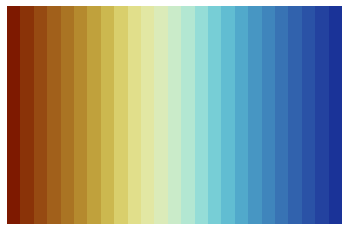

In [2]:
mapname = 'roma'

cm_data = np.loadtxt(f"/home/mperkonigg/Documents/ScientificColourMaps6/{mapname}/{mapname}.txt")
colormap = LinearSegmentedColormap.from_list('scientific_cm', cm_data)
x = np.linspace(0, 100, 25)[None, :]
plt.imshow(x, aspect='auto',cmap=colormap)
plt.axis('off')
plt.show()
matplotlib.cm.register_cmap(cmap=colormap, name='scientific_cm')
sns.set_palette('scientific_cm')

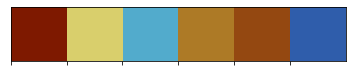

In [3]:
cm_data = np.loadtxt(f"/home/mperkonigg/Documents/ScientificColourMaps6/{mapname}/{mapname}.txt")
#colormap = LinearSegmentedColormap.from_list('scientific_cm', cm_data)
#x = np.linspace(0, 100, 25)[None, :]
#plt.imshow(x, aspect='auto',cmap=colormap)
#plt.axis('off')
#plt.show()
colormap = ListedColormap([cm_data[0], cm_data[85],cm_data[180], cm_data[45], cm_data[20], cm_data[227]], name='scientific_cm')
matplotlib.cm.register_cmap(cmap=colormap, name='scientific_cm')
sns.set_palette('scientific_cm')
sns.palplot(sns.color_palette())

In [23]:
hparams = {
    'continuous': False,
    'datasetfile': '/project/catinous/cardiacslicessplit.csv',
    'batch_size': 16,
    'training_batch_size': 16,
    'task': 'cardiac',
    'model': 'fcn',
    'scanner': 'Siemens',
     'noncontinuous_steps': 500,
    'noncontinuous_train_splits': ['base', 'train'],
    'use_memory': False
}

val_dice1_Siemens = []
val_dice2_Siemens = []
val_dice3_Siemens = []
val_dice1_GE = []
val_dice1_Philips = []
val_dice1_Canon = []

for scanner in ['Siemens', 'GE', 'Philips', 'Canon', None]:
    hparams['scanner'] = scanner
    if scanner is None:
        hparams['order'] = ['Siemens', 'GE', 'Philips', 'Canon']
    #model, logs, df_cache = catsmodel.trained_model(hparams)
    expparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)
    exp_name = cutils.get_expname(expparams)

    max_version = max([int(x.split('_')[1]) for x in os.listdir(cutils.LOGGING_FOLDER + exp_name)])
    logs = pd.read_csv(cutils.LOGGING_FOLDER + exp_name + '/version_{}/metrics.csv'.format(max_version))
    
    val_dice1_Siemens.append(logs.iloc[-1].val_dice1_Siemens)
    val_dice1_GE.append(logs.iloc[-1].val_dice1_GE)
    val_dice1_Philips.append(logs.iloc[-1].val_dice1_Philips)
    val_dice1_Canon.append(logs.iloc[-1].val_dice1_Canon)

pd.DataFrame({'scanner': ['Siemens', 'GE', 'Philips', 'Canon', None], 'val_Siemens': val_dice1_Siemens, 
              'val_GE': val_dice1_GE, 'val_Philips': val_dice1_Philips, 'val_Canon': val_dice1_Canon})

,scanner,val_Siemens,val_GE,val_Philips,val_Canon
0,Siemens,0.807649,0.827656,0.843444,0.801174
1,GE,0.712092,0.826061,0.786773,0.774519
2,Philips,0.745954,0.782469,0.860170,0.828817
3,Canon,0.714380,0.752285,0.746388,0.878775
4,None,0.836838,0.848288,0.853259,0.875537


In [4]:
def res_data_for_params(hparams, seeds=None):
    df = pd.DataFrame()
    hparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)
    if seeds is None:        
        exp_name = cutils.get_expname(hparams)

        max_version = max([int(x.split('_')[1]) for x in os.listdir(cutils.LOGGING_FOLDER + exp_name)])
        df_temp = pd.read_csv(cutils.LOGGING_FOLDER + exp_name + '/version_{}/metrics.csv'.format(max_version))

        df_temp = df_temp.loc[df_temp['val_dice1_Canon']==df_temp['val_dice1_Canon']]
        df_temp['idx'] = range(1,len(df_temp)+1)
        df = df.append(df_temp)
    else:
        for i, seed in enumerate(seeds):
            hparams['seed'] = seed
            hparams['run_postfix'] = i+1
            exp_name = cutils.get_expname(hparams)
            max_version = max([int(x.split('_')[1]) for x in os.listdir(cutils.LOGGING_FOLDER + exp_name)])
            df_temp = pd.read_csv(cutils.LOGGING_FOLDER + exp_name + '/version_{}/metrics.csv'.format(max_version))

            df_temp = df_temp.loc[df_temp['val_dice1_Canon']==df_temp['val_dice1_Canon']]
            df_temp['idx'] = range(1,len(df_temp)+1)
            df = df.append(df_temp)
    #if os.path.exists(cutils.TRAINED_MEMORY_FOLDER + exp_name + '.csv'):
    #    df_mem = pd.read_csv(cutils.TRAINED_MEMORY_FOLDER + exp_name + '.csv')
    #else:
    #    print(cutils.TRAINED_MEMORY_FOLDER + exp_name + '.csv', 'not existing')
    #    df_mem = None
    
    df['val_mean_Canon'] = (df['val_dice1_Canon'] + df['val_dice2_Canon'] + df['val_dice3_Canon'])/3
    df['val_mean_GE'] = (df['val_dice1_GE'] + df['val_dice2_GE'] + df['val_dice3_GE'])/3
    df['val_mean_Siemens'] = (df['val_dice1_Siemens'] + df['val_dice2_Siemens'] + df['val_dice3_Siemens'])/3
    df['val_mean_Philips'] = (df['val_dice1_Philips'] + df['val_dice2_Philips'] + df['val_dice3_Philips'])/3

    return df#, df_mem

ds = ContinuousDataset.CardiacContinuous('/project/catinous/cardiacslicessplitsingle.csv', seed=1654130)
res = ds.df.scanner == 'Siemens'
res1 = ds.df.scanner == 'GE'
res2 = ds.df.scanner == 'Philips'
res3 = ds.df.scanner == 'Canon'
res[res1] = 2
res[res2] = 3
res[res3] = 4

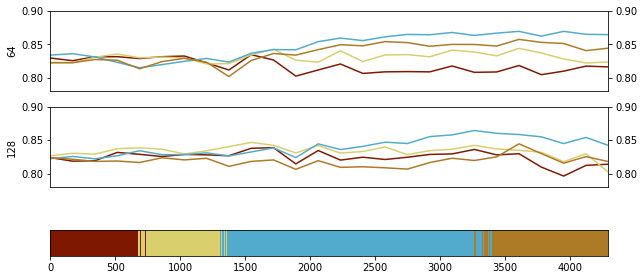

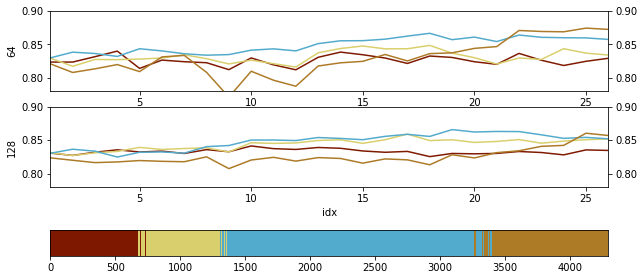

In [27]:
hparams={'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 16,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': False,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'noncontinuous_steps': 3000,
         'noncontinuous_train_splits': ['train', 'base_train'],
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0.pt',
        'run_postfix': 1,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130
        }


hparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)
memorymaximas = [64, 128]
#hparams['stylemodel'] = True

fig, axes = plt.subplots(3, 1, figsize=(10, 5))

for i, mm in enumerate(memorymaximas):
    hparams['memorymaximum'] = mm
    df, df_mem = res_data_for_params(hparams)

    ax = axes[i]
    sns.lineplot(data=df, y='val_dice1_Siemens', x='idx', err_style=None, ax=ax, label='Siemens')
    sns.lineplot(data=df, y='val_dice1_GE', x='idx', err_style=None, ax=ax, label='GE')
    sns.lineplot(data=df, y='val_dice1_Philips', x='idx', err_style=None, ax=ax, label='Philips')
    sns.lineplot(data=df, y='val_dice1_Canon', x='idx', err_style=None, ax=ax, label='Canon')
    ax.set_ylim(0.78, 0.90)
    ax.get_xaxis().set_visible(False)
    ax.get_legend().remove()
    ax.set_xlim(1, 26)
    ax.set_ylabel(f'{mm}')
    ax.tick_params(labelright=True, right=True)


axes[2].imshow(np.tile(res,(200,1)), cmap=ListedColormap(colormap.colors[:4]))
axes[2].get_yaxis().set_visible(False)
axes[2].get_yaxis()

hparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)
memorymaximas = [64, 128]

fig, axes = plt.subplots(3, 1, figsize=(10, 5))
hparams['stylemodel'] = True
for i, mm in enumerate(memorymaximas):
    hparams['memorymaximum'] = mm
    df, df_mem = res_data_for_params(hparams)

    ax = axes[i]
    sns.lineplot(data=df, y='val_dice1_Siemens', x='idx', err_style=None, ax=ax, label='Siemens')
    sns.lineplot(data=df, y='val_dice1_GE', x='idx', err_style=None, ax=ax, label='GE')
    sns.lineplot(data=df, y='val_dice1_Philips', x='idx', err_style=None, ax=ax, label='Philips')
    sns.lineplot(data=df, y='val_dice1_Canon', x='idx', err_style=None, ax=ax, label='Canon')
    ax.set_ylim(0.78, 0.9)
    ax.set_xlim(1, 26)
    ax.set_ylabel(f'{mm}')
    ax.get_legend().remove()
    ax.tick_params(labelright=True, right=True)



axes[2].imshow(np.tile(res,(200,1)), cmap=ListedColormap(colormap.colors[:4]))
axes[2].get_yaxis().set_visible(False)
axes[2].get_yaxis()

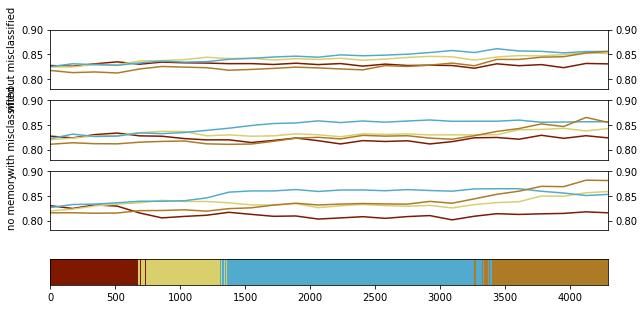

In [24]:
seeds = [1654130, 6654961, 5819225, 1215862, 132054]

hparams={'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 16,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': False,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0.pt',
        'run_postfix': 5,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 132054,
         'stylemodel': True
        }


hparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)

fig, axes = plt.subplots(4, 1, figsize=(10, 5))

df = res_data_for_params(hparams, seeds=seeds)

ax = axes[0]
sns.lineplot(data=df, y='val_dice1_Siemens', x='idx', err_style=None, ax=ax, label='Siemens')
sns.lineplot(data=df, y='val_dice1_GE', x='idx', err_style=None, ax=ax, label='GE')
sns.lineplot(data=df, y='val_dice1_Philips', x='idx', err_style=None, ax=ax, label='Philips')
sns.lineplot(data=df, y='val_dice1_Canon', x='idx', err_style=None, ax=ax, label='Canon')
ax.set_ylim(0.78, 0.90)
ax.get_xaxis().set_visible(False)
ax.get_legend().remove()
ax.set_xlim(1, 26)
ax.set_ylabel(f'without misclassified')
ax.tick_params(labelright=True, right=True)

hparams['force_misclassified'] = True
hparams['misclass_threshold'] = 0.80

df = res_data_for_params(hparams, seeds=seeds)
ax = axes[1]
sns.lineplot(data=df, y='val_dice1_Siemens', x='idx', err_style=None, ax=ax, label='Siemens')
sns.lineplot(data=df, y='val_dice1_GE', x='idx', err_style=None, ax=ax, label='GE')
sns.lineplot(data=df, y='val_dice1_Philips', x='idx', err_style=None, ax=ax, label='Philips')
sns.lineplot(data=df, y='val_dice1_Canon', x='idx', err_style=None, ax=ax, label='Canon')
ax.set_ylim(0.78, 0.90)
ax.get_xaxis().set_visible(False)
ax.get_legend().remove()
ax.set_xlim(1, 26)
ax.set_ylabel(f'with misclassified')
ax.tick_params(labelright=True, right=True)

hparams={'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 16,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':False,
         'random_memory': True,
         'balance_memory': False,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0.pt',
        'run_postfix': 1,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130
        }

df = res_data_for_params(hparams, seeds=seeds)
ax = axes[2]
sns.lineplot(data=df, y='val_dice1_Siemens', x='idx', err_style=None, ax=ax, label='Siemens')
sns.lineplot(data=df, y='val_dice1_GE', x='idx', err_style=None, ax=ax, label='GE')
sns.lineplot(data=df, y='val_dice1_Philips', x='idx', err_style=None, ax=ax, label='Philips')
sns.lineplot(data=df, y='val_dice1_Canon', x='idx', err_style=None, ax=ax, label='Canon')
ax.set_ylim(0.78, 0.90)
ax.get_xaxis().set_visible(False)
ax.get_legend().remove()
ax.set_xlim(1, 26)
ax.set_ylabel(f'no memory')
ax.tick_params(labelright=True, right=True)


axes[3].imshow(np.tile(res,(200,1)), cmap=ListedColormap(colormap.colors[:4]))
axes[3].get_yaxis().set_visible(False)
axes[3].get_yaxis()

cardiac_cont_cardiacslicessplitsingle_basemodel_batch_mem_tf08_1_2dcec06909
{'root_dir': '/project/catinous/', 'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv', 'batch_size': 16, 'training_batch_size': 16, 'transition_phase_after': 0.8, 'memorymaximum': 128, 'use_memory': True, 'random_memory': True, 'balance_memory': False, 'order': ['Siemens', 'GE', 'Philips', 'Canon'], 'continuous': True, 'noncontinuous_steps': 3000, 'noncontinuous_train_splits': ['train', 'base_train'], 'val_check_interval': 10, 'base_model': 'cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0.pt', 'run_postfix': 1, 'dim': 2, 'task': 'cardiac', 'model': 'fcn', 'seed': 1654130, 'stylemodel': True}
cardiac_cont_cardiacslicessplitsingle_basemodel_batch_mem_tf08_1_517c977465
{'root_dir': '/project/catinous/', 'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv', 'batch_size': 16, 'training_batch_size': 16, 'transition_phase_after': 0.8, 'memorymaximum': 128, 'use_memory': True, 'random_memory'

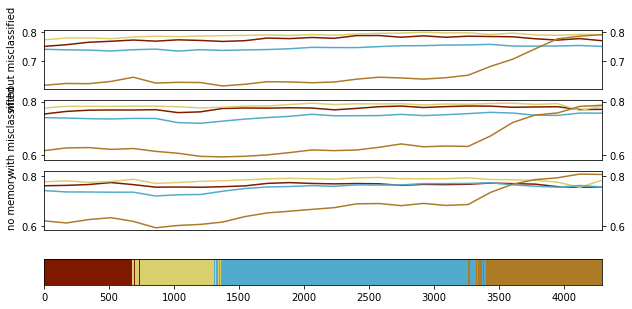

In [28]:
seeds = [1654130, 6654961, 5819225, 1215862, 132054]

val_measure = 'val_dice3'


hparams={'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 16,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': False,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0.pt',
        'run_postfix': 5,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 132054,
         'stylemodel': True
        }


hparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)

fig, axes = plt.subplots(4, 1, figsize=(10, 5))

df = res_data_for_params(hparams, seeds=seeds)

ax = axes[0]
for scanner in hparams['order']:
    sns.lineplot(data=df, y=f'{val_measure}_{scanner}', x='idx', err_style=None, ax=ax, label=scanner)
#ax.set_ylim(0.78, 0.90)
ax.get_xaxis().set_visible(False)
ax.get_legend().remove()
ax.set_xlim(1, 26)
ax.set_ylabel(f'without misclassified')
ax.tick_params(labelright=True, right=True)

hparams['force_misclassified'] = True
hparams['misclass_threshold'] = 0.8

df = res_data_for_params(hparams, seeds=seeds)
ax = axes[1]
for scanner in hparams['order']:
    sns.lineplot(data=df, y=f'{val_measure}_{scanner}', x='idx', err_style=None, ax=ax, label=scanner)
#ax.set_ylim(0.78, 0.90)
ax.get_xaxis().set_visible(False)
ax.get_legend().remove()
ax.set_xlim(1, 26)
ax.set_ylabel(f'with misclassified')
ax.tick_params(labelright=True, right=True)

hparams={'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 16,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':False,
         'random_memory': True,
         'balance_memory': False,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0.pt',
        'run_postfix': 1,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130
        }

df = res_data_for_params(hparams, seeds=seeds)
ax = axes[2]
for scanner in hparams['order']:
    sns.lineplot(data=df, y=f'{val_measure}_{scanner}', x='idx', err_style=None, ax=ax, label=scanner)
#ax.set_ylim(0.78, 0.90)
ax.get_xaxis().set_visible(False)
ax.get_legend().remove()
ax.set_xlim(1, 26)
ax.set_ylabel(f'no memory')
ax.tick_params(labelright=True, right=True)


axes[3].imshow(np.tile(res,(200,1)), cmap=ListedColormap(colormap.colors[:4]))
axes[3].get_yaxis().set_visible(False)
axes[3].get_yaxis()

In [31]:

df

,created_at,epoch,train_loss,val_dice1_Canon,val_dice1_GE,val_dice1_Philips,val_dice1_Siemens,val_dice2_Canon,val_dice2_GE,val_dice2_Philips,val_dice2_Siemens,val_dice3_Canon,val_dice3_GE,val_dice3_Philips,val_dice3_Siemens,idx,val_mean_Canon,val_mean_GE,val_mean_Siemens,val_mean_Philips
0,2021-01-11 10:41:37.383322,NaN,NaN,0.823241,0.824004,0.828219,0.829606,0.664965,0.732215,0.756871,0.723660,0.622050,0.774352,0.742843,0.749166,1,0.703419,0.776857,0.767477,0.775978
1,2021-01-11 10:41:47.699709,NaN,NaN,0.819963,0.817112,0.832881,0.814098,0.663100,0.744514,0.754933,0.717598,0.615944,0.781830,0.736143,0.762967,2,0.699669,0.781152,0.764888,0.774652
2,2021-01-11 10:41:58.120596,NaN,NaN,0.815884,0.826288,0.834061,0.831348,0.655539,0.727395,0.748074,0.740688,0.624553,0.773788,0.738809,0.765870,3,0.698659,0.775824,0.779302,0.773648
3,2021-01-11 10:42:09.553293,NaN,NaN,0.819038,0.834202,0.833769,0.834558,0.664271,0.736623,0.736482,0.737270,0.630541,0.782881,0.741044,0.784216,4,0.704617,0.784568,0.785348,0.770432
5,2021-01-11 10:42:20.205168,NaN,NaN,0.808335,0.833482,0.830423,0.802783,0.678978,0.762977,0.754375,0.704584,0.602039,0.782621,0.723952,0.763173,5,0.696451,0.793027,0.756847,0.769583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,2021-01-11 13:52:06.791966,NaN,NaN,0.868540,0.839096,0.864224,0.812568,0.782912,0.788476,0.801927,0.710419,0.782344,0.773909,0.766461,0.767722,22,0.811265,0.800494,0.763570,0.810871
26,2021-01-11 13:52:16.705654,NaN,NaN,0.876295,0.850827,0.859205,0.813155,0.775197,0.790493,0.784549,0.703460,0.786717,0.776570,0.762352,0.756904,23,0.812736,0.805963,0.757840,0.802035
27,2021-01-11 13:52:27.027150,NaN,NaN,0.870056,0.844052,0.855872,0.805554,0.780625,0.789719,0.779426,0.698971,0.775796,0.779391,0.741254,0.756291,24,0.808826,0.804387,0.753605,0.792184
29,2021-01-11 13:52:37.516277,NaN,NaN,0.886945,0.860884,0.858928,0.828493,0.788065,0.791657,0.778979,0.701089,0.810906,0.780875,0.757927,0.771218,25,0.828639,0.811139,0.766933,0.798611


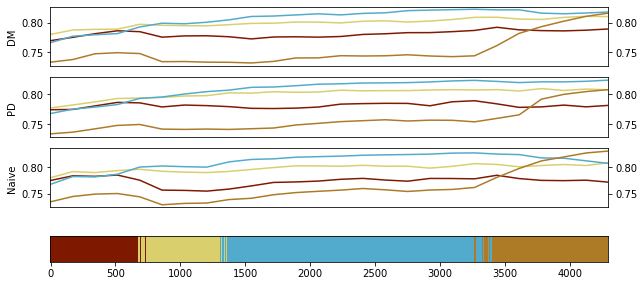

In [35]:
seeds = [1654130, 6654961, 5819225, 1215862, 132054]

val_measure = 'val_mean'

hparams={'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 16,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': False,
         'force_misclassified': True,
         'misclass_threshold': 0.8,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplitsingle_base_1_ebc3df72a1.pt', #'cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0.pt',
        'run_postfix': 1,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130,
         'stylemodel': True
        }


hparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)

fig, axes = plt.subplots(4, 1, figsize=(10, 5))

df = res_data_for_params(hparams, seeds=seeds)

ax = axes[0]
for scanner in hparams['order']:
    sns.lineplot(data=df, y=f'{val_measure}_{scanner}', x='idx', err_style=None, ax=ax, label=scanner)
#ax.set_ylim(0.78, 0.90)
ax.get_xaxis().set_visible(False)
ax.get_legend().remove()
ax.set_xlim(1, 26)
ax.set_ylabel(f'DM')
ax.tick_params(labelright=True, right=True)

hparams={'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 16,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': False,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplitsingle_base_1_ebc3df72a1.pt', # cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0
        'run_postfix': 1,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130,
         'stylemodel': True,
         'pseudodomain_detection': True
        }

#hparams['force_misclassified'] = True
#hparams['misclass_threshold'] = 0.80
df = res_data_for_params(hparams, seeds=seeds)

ax = axes[1]
for scanner in hparams['order']:
    sns.lineplot(data=df, y=f'{val_measure}_{scanner}', x='idx', err_style=None, ax=ax, label=scanner)
#ax.set_ylim(0.78, 0.90)
ax.get_xaxis().set_visible(False)
ax.get_legend().remove()
ax.set_xlim(1, 26)
ax.set_ylabel(f'PD')
ax.tick_params(labelright=True, right=True)

hparams={'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 16,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':False,
         'random_memory': True,
         'balance_memory': False,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplitsingle_base_1_ebc3df72a1.pt',#'cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0.pt',
        'run_postfix': 1,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130
        }

df = res_data_for_params(hparams, seeds=seeds)
ax = axes[2]
for scanner in hparams['order']:
    sns.lineplot(data=df, y=f'{val_measure}_{scanner}', x='idx', err_style=None, ax=ax, label=scanner)
#ax.set_ylim(0.78, 0.90)
ax.get_xaxis().set_visible(False)
ax.get_legend().remove()
ax.set_xlim(1, 26)
ax.set_ylabel(f'Naive')
ax.tick_params(labelright=True, right=True)


axes[3].imshow(np.tile(res,(200,1)), cmap=ListedColormap(colormap.colors[:4]))
axes[3].get_yaxis().set_visible(False)
axes[3].get_yaxis()

In [6]:
df_overall = pd.DataFrame()

In [12]:
seeds = [1654130, 6654961, 5819225, 1215862, 132054]

hparams={'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 16,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': False,
         'force_misclassified': True,
         'misclass_threshold': 0.8,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplitsingle_base_1_ebc3df72a1.pt', #'cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0.pt',
        'run_postfix': 1,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130,
         'stylemodel': True
        }
name = 'force'

#hparams['force_misclassified'] = True
#hparams['misclass_threshold'] = 0.80

hparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)
df_means = pd.DataFrame()
for i, seed in enumerate(seeds):
    hparams['seed'] = seed
    hparams['run_postfix'] = i+1

    df = pd.read_csv(f'/project/catinous/results/cardiac/{cutils.get_expname(hparams)}_dicescores.csv')
    df_temp = df.groupby(['scanner', 'shift']).mean().reset_index()
    df_temp['seed'] = seed
    df_means = df_means.append(df_temp)

df_res = df_means.loc[df_means['shift']=='None'].drop(columns=['seed'])

for seed in seeds:
    df_bwt_fwt = df_means.loc[df_means.seed==seed].groupby(['scanner', 'shift']).mean().reset_index()

    order = ['Siemens', 'GE', 'Philips', 'Canon']
    bwt = {'dice_1': 0.0, 'dice_2': 0.0, 'dice_3': 0.0}
    fwt = {'dice_1': 0.0, 'dice_2': 0.0, 'dice_3': 0.0}

    for i in range(len(order)-1):
        df_scanner = df_bwt_fwt.loc[df_bwt_fwt.scanner==order[i]]
        bwt['dice_1'] += df_scanner.loc[df_scanner['shift']=='None'].dice_1.values[0] - df_scanner.loc[df_scanner['shift']==order[i+1]].dice_1.values[0]
        bwt['dice_2'] += df_scanner.loc[df_scanner['shift']=='None'].dice_2.values[0] - df_scanner.loc[df_scanner['shift']==order[i+1]].dice_2.values[0]
        bwt['dice_3'] += df_scanner.loc[df_scanner['shift']=='None'].dice_3.values[0] - df_scanner.loc[df_scanner['shift']==order[i+1]].dice_3.values[0]

    order = ['Siemens', 'GE', 'Philips', 'Canon', 'None']

    for i in range(2, len(order)):
        df_scanner = df_bwt_fwt.loc[df_bwt_fwt.scanner==order[i-1]]
        fwt['dice_1'] += df_scanner.loc[df_scanner['shift']==order[i]].dice_1.values[0] - df_scanner.loc[df_scanner['shift']==order[1]].dice_1.values[0]
        fwt['dice_2'] += df_scanner.loc[df_scanner['shift']==order[i]].dice_2.values[0] - df_scanner.loc[df_scanner['shift']==order[1]].dice_2.values[0]
        fwt['dice_3'] += df_scanner.loc[df_scanner['shift']==order[i]].dice_3.values[0] - df_scanner.loc[df_scanner['shift']==order[1]].dice_3.values[0]


    bwt['dice_1'] /= len(order)-1
    bwt['dice_2'] /= len(order)-1
    bwt['dice_3'] /= len(order)-1

    #bwt['mean'] = (bwt['dice_1']+bwt['dice_2']+bwt['dice_3'])/3

    fwt['dice_1'] /= len(order)-1
    fwt['dice_2'] /= len(order)-1
    fwt['dice_3'] /= len(order)-1
    df_res = df_res.append(pd.DataFrame({'scanner': ['BWT', 'FWT'], 'shift':['None', 'None'], 
                                'dice_1':[bwt['dice_1'], fwt['dice_1']], 
                                'dice_2':[bwt['dice_2'], fwt['dice_2']], 
                                'dice_3':[bwt['dice_3'], fwt['dice_3']]}))


    #fwt['mean'] = (fwt['dice_1']+fwt['dice_2']+fwt['dice_3'])/3
df_res['mean'] = df_res.mean(axis=1)
df_res['model'] = name

df_overall = df_overall.append(df_res)

In [21]:
df_overview = df_overall.groupby(['model', 'scanner']).mean().reset_index()
df_overview.pivot(index='model', columns='scanner', values='mean').round(3)

scanner,BWT,Canon,FWT,GE,Philips,Siemens
model,,,,,,
force,-0.001,0.833,0.029,0.752,0.798,0.794
no_mem,-0.013,0.839,0.029,0.737,0.790,0.779
pseudo,-0.003,0.819,0.026,0.757,0.799,0.785
wo_force,-0.000,0.819,0.027,0.763,0.801,0.793


In [41]:
df_overview = df_overall.groupby(['model', 'scanner']).std().reset_index()
df_overview.pivot(index='model', columns='scanner', values='mean').round(3)

scanner,BWT,Canon,FWT,GE,Philips,Siemens
model,,,,,,
force,0.005,0.004,0.002,0.006,0.003,0.009
no_mem,0.003,0.006,0.003,0.006,0.002,0.003
pseudo,0.006,0.007,0.005,0.011,0.003,0.007
wo_force,0.007,0.012,0.004,0.012,0.005,0.007


In [38]:
df_overview.to_csv('/project/catinous/results/overview_testset.csv', index=False)

In [56]:
hparams = {
    'continuous': False,
    'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
    'batch_size': 16,
    'training_batch_size': 16,
    'task': 'cardiac',
    'model': 'fcn',
    'scanner': None,
     'noncontinuous_steps': 1000,
    'noncontinuous_train_splits': ['base', 'train'],
    'use_memory': False
}
hparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)
df = pd.read_csv(f'/project/catinous/results/cardiac/{cutils.get_expname(hparams)}_dicescores.csv')
#dmodel.cached_path(hparams)

In [77]:
hparams = {
    'continuous': False,
    'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
    'batch_size': 16,
    'training_batch_size': 16,
    'task': 'cardiac',
    'model': 'fcn',
    'scanner': None,
     'noncontinuous_steps': 1000,
    'noncontinuous_train_splits': ['base', 'train'],
    'use_memory': False
}
hparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)

df_means = pd.DataFrame()
for scanner in ['Siemens', 'GE', 'Philips', 'Canon', None]:
    hparams['scanner'] = scanner
    for i in range(5):
        hparams['run_postfix'] = i+1

        df = pd.read_csv(f'/project/catinous/results/cardiac/{cutils.get_expname(hparams)}_dicescores.csv')
        df_temp = df.groupby(['scanner']).mean().reset_index()
        if scanner is None:
            df_temp['model'] = 'Joint'
        else:
            df_temp['model'] = scanner
        df_means = df_means.append(df_temp)

df_means['mean'] = df_means.mean(axis=1)


In [79]:
df_overview = df_means.groupby(['model', 'scanner']).mean().reset_index()
df_overview.pivot(index='model', columns='scanner', values='mean').round(3)

scanner,Canon,GE,Philips,Siemens
model,,,,
Canon,0.835,0.605,0.689,0.662
GE,0.694,0.748,0.719,0.676
Joint,0.852,0.798,0.823,0.822
Philips,0.755,0.722,0.806,0.755
Siemens,0.725,0.754,0.771,0.802


In [80]:
df_overview = df_means.groupby(['model', 'scanner']).std().reset_index()
df_overview.pivot(index='model', columns='scanner', values='mean').round(3)

scanner,Canon,GE,Philips,Siemens
model,,,,
Canon,0.005,0.033,0.029,0.025
GE,0.037,0.012,0.028,0.020
Joint,0.007,0.016,0.006,0.010
Philips,0.034,0.014,0.014,0.012
Siemens,0.013,0.027,0.025,0.017


In [5]:
df_overall = pd.DataFrame()

In [7]:
seeds = [1654130, 6654961, 5819225, 1215862, 132054]

hparams={'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 16,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 64,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': False,
         'force_misclassified': True,
         'misclass_threshold': 0.8,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplitsingle_base_1_ebc3df72a1.pt', #'cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0.pt',
        'run_postfix': 1,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130,
         'stylemodel': True
        }

hparams={'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 16,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 64,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': False,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplitsingle_base_1_ebc3df72a1.pt', # cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0
        'run_postfix': 1,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130,
         'stylemodel': True,
         'pseudodomain_detection': True
        }

name = '64_PD'

#hparams['force_misclassified'] = True
#hparams['misclass_threshold'] = 0.80

hparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)
df_means = pd.DataFrame()
for i, seed in enumerate(seeds):
    hparams['seed'] = seed
    hparams['run_postfix'] = i+1

    df = pd.read_csv(f'/project/catinous/results/cardiac/{cutils.get_expname(hparams)}_dicescores.csv')
    df_temp = df.groupby(['scanner', 'shift']).mean().reset_index()
    df_temp['seed'] = seed
    df_means = df_means.append(df_temp)

df_res = df_means.loc[df_means['shift']=='None'].drop(columns=['seed'])

for seed in seeds:
    df_bwt_fwt = df_means.loc[df_means.seed==seed].groupby(['scanner', 'shift']).mean().reset_index()

    order = ['Siemens', 'GE', 'Philips', 'Canon']
    bwt = {'dice_1': 0.0, 'dice_2': 0.0, 'dice_3': 0.0}
    fwt = {'dice_1': 0.0, 'dice_2': 0.0, 'dice_3': 0.0}

    for i in range(len(order)-1):
        df_scanner = df_bwt_fwt.loc[df_bwt_fwt.scanner==order[i]]
        bwt['dice_1'] += df_scanner.loc[df_scanner['shift']=='None'].dice_1.values[0] - df_scanner.loc[df_scanner['shift']==order[i+1]].dice_1.values[0]
        bwt['dice_2'] += df_scanner.loc[df_scanner['shift']=='None'].dice_2.values[0] - df_scanner.loc[df_scanner['shift']==order[i+1]].dice_2.values[0]
        bwt['dice_3'] += df_scanner.loc[df_scanner['shift']=='None'].dice_3.values[0] - df_scanner.loc[df_scanner['shift']==order[i+1]].dice_3.values[0]

    order = ['Siemens', 'GE', 'Philips', 'Canon', 'None']

    for i in range(2, len(order)):
        df_scanner = df_bwt_fwt.loc[df_bwt_fwt.scanner==order[i-1]]
        fwt['dice_1'] += df_scanner.loc[df_scanner['shift']==order[i]].dice_1.values[0] - df_scanner.loc[df_scanner['shift']==order[1]].dice_1.values[0]
        fwt['dice_2'] += df_scanner.loc[df_scanner['shift']==order[i]].dice_2.values[0] - df_scanner.loc[df_scanner['shift']==order[1]].dice_2.values[0]
        fwt['dice_3'] += df_scanner.loc[df_scanner['shift']==order[i]].dice_3.values[0] - df_scanner.loc[df_scanner['shift']==order[1]].dice_3.values[0]


    bwt['dice_1'] /= len(order)-1
    bwt['dice_2'] /= len(order)-1
    bwt['dice_3'] /= len(order)-1

    #bwt['mean'] = (bwt['dice_1']+bwt['dice_2']+bwt['dice_3'])/3

    fwt['dice_1'] /= len(order)-1
    fwt['dice_2'] /= len(order)-1
    fwt['dice_3'] /= len(order)-1
    df_res = df_res.append(pd.DataFrame({'scanner': ['BWT', 'FWT'], 'shift':['None', 'None'], 
                                'dice_1':[bwt['dice_1'], fwt['dice_1']], 
                                'dice_2':[bwt['dice_2'], fwt['dice_2']], 
                                'dice_3':[bwt['dice_3'], fwt['dice_3']]}))


    #fwt['mean'] = (fwt['dice_1']+fwt['dice_2']+fwt['dice_3'])/3
df_res['mean'] = df_res.mean(axis=1)
df_res['model'] = name

df_overall = df_overall.append(df_res)

In [8]:
df_overview = df_overall.groupby(['model', 'scanner']).mean().reset_index()
df_overview.pivot(index='model', columns='scanner', values='mean').round(3)

scanner,BWT,Canon,FWT,GE,Philips,Siemens
model,,,,,,
64,-0.005,0.831,0.027,0.747,0.797,0.785
64_PD,-0.005,0.830,0.026,0.744,0.795,0.783


In [9]:
df_overview = df_overall.groupby(['model', 'scanner']).std().reset_index()
df_overview.pivot(index='model', columns='scanner', values='mean').round(3)

scanner,BWT,Canon,FWT,GE,Philips,Siemens
model,,,,,,
64,0.005,0.009,0.003,0.005,0.008,0.008
64_PD,0.005,0.010,0.005,0.011,0.006,0.005
